In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

# Fetch PES Points 

In [3]:
path = "../TaskC/pes.tab"

r = []
E_HF = []
E_CCSDT = []

with open(path, "r") as f:
    for line in f:
        try:
            splits = list(map(float, line.split()))

            r.append(splits[0])
            E_HF.append(splits[1])
            E_CCSDT.append(splits[2])
        except:
            pass
        
#r = np.asarray(r)
E_HF = np.asarray(E_HF)
E_CCSDT = np.asarray(E_CCSDT)

### Convert energies to SI: Hartree -> Joule 

In [4]:
from scipy.constants import physical_constants

conversion_hartree_to_joule = physical_constants["Hartree energy"][0]

E_HF *= conversion_hartree_to_joule
E_CCSDT *= conversion_hartree_to_joule

# PChip Interpolation 

In [5]:
from scipy.interpolate import PchipInterpolator as PChip

interpolator_HF = PChip(r, E_HF)
interpolator_CCSDT = PChip(r, E_CCSDT)

# Display PES 

## Data 

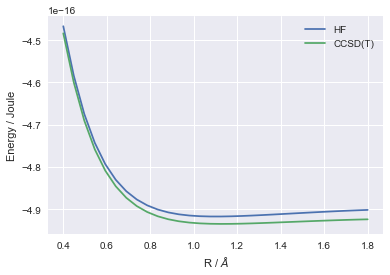

In [6]:
plt.plot(r, E_HF, label="HF")
plt.plot(r, E_CCSDT, label="CCSD(T)")

plt.xlabel("R / $\AA$")
plt.ylabel("Energy / Joule")

plt.legend()

## Interpolated 

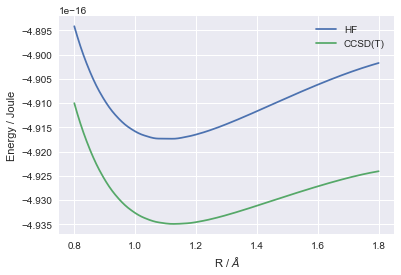

In [7]:
t = np.linspace(0.8, 1.8, 500)

plt.plot(t, interpolator_HF(t), label="HF")
plt.plot(t, interpolator_CCSDT(t), label="CCSD(T)")

plt.xlabel("R / $\AA$")
plt.ylabel("Energy / Joule")

plt.legend()

# Make Hamiltonian 

In [88]:
# dimensio of hamiltonian
N = 1000
r0 = 0.8
r1 = 1.8

In [89]:
from scipy.constants import physical_constants

u = physical_constants["atomic mass constant"][0]

m_C = 12 * u
m_O = 16 * u

## Kinetic Term

In [90]:
from scipy.constants import hbar
from scipy.sparse import diags

mu = m_C * m_O / (m_C + m_O)

dr = (r1-r0) / N 
dr *= 1e-10 # angstrom

P = hbar**2 / (2 * mu * dr**2) * (
    diags(2 * np.ones(N)) + \
    diags(-1 * np.ones(N-1), -1) + \
    diags(-1 * np.ones(N-1), +1)
)

np.mean(P)

9.766973735654815e-23

In [91]:
hbar, m_C, m_O, dr

(1.0545718001391127e-34, 1.992646848e-26, 2.656862464e-26, 1e-13)

## Potential Term 

In [92]:
r = np.linspace(r0, r1, N)
#r = np.linspace(1.0, 1.325, N)

U_HF = diags(interpolator_HF(r))
U_CCSDT = diags(interpolator_CCSDT(r))

np.mean(U_HF)

-4.910387718190623e-19

## H = P + U 

In [93]:
H_HF = P + U_HF
H_CCSDT = P + U_CCSDT

#  Solve Finite Differences Equations


Eigenvalueproblem: $\hat{H} |\psi\rangle = E |\psi\rangle$

Finite differences: $\psi = \{\psi_1, \psi_2, \ldots, \psi_n\}$

In [94]:
# numer of eigen values 
n = 10

In [95]:
from scipy.constants import physical_constants
conversion_joule_to_eV = 1 / physical_constants["electron volt"][0]

## HF 

In [96]:
from scipy.sparse.linalg import eigsh

E, psi = eigsh(H_HF, n)

In [97]:
print(E[:np.min([20, len(E)])] * conversion_joule_to_eV)

[-3069.04152215 -3068.75761476 -3068.45459541 -3068.16441475
 -3067.87477805 -3067.58731692 -3067.3014603  -3067.02131961
 -3066.74243308 -3066.46595879]


In [98]:
print(np.diff(E[:np.min([20, len(E)])]) * conversion_joule_to_eV)

[0.28390739 0.30301935 0.29018066 0.2896367  0.28746113 0.28585662
 0.28014069 0.27888653 0.2764743 ]


Text(0,0.5,'$\\psi$ / AU')

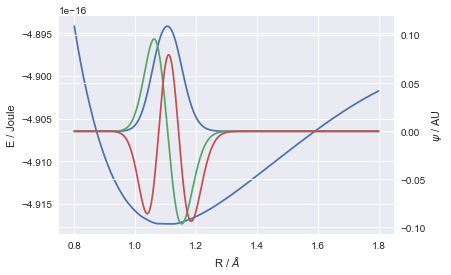

In [99]:
t = r0 + np.arange(N) * dr*1e10

fig, ax1 = plt.subplots()

ax1.plot(t, interpolator_HF(t), label="V_HF")
ax1.set_xlabel("R / $\AA$")
ax1.set_ylabel("E / Joule")


ax2 = ax1.twinx()
for i in range(3):
    ax2.plot(t, psi[:,i], label="State-" + str(i))
ax2.set_ylabel("$\psi$ / AU")

## CCSD(T) 

In [100]:
E, psi = eigsh(H_CCSDT, n)

In [101]:
print(E[:np.min([20, len(E)])] * conversion_joule_to_eV)

[-3079.98673756 -3079.72621521 -3079.46376213 -3079.20694818
 -3078.94991601 -3078.69912024 -3078.4508525  -3078.20520518
 -3077.96227531 -3077.72331954]


In [102]:
print(np.diff(E[:np.min([20, len(E)])]) * conversion_joule_to_eV)

[0.26052235 0.26245308 0.25681395 0.25703217 0.25079577 0.24826774
 0.24564732 0.24292987 0.23895577]


Text(0,0.5,'$\\psi$ / AU')

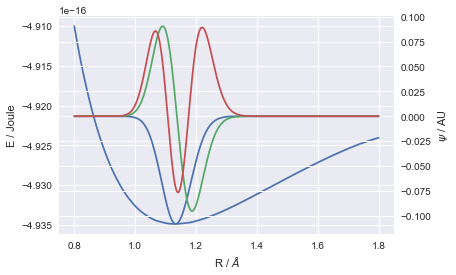

In [103]:
t = r0 + np.arange(N) * dr*1e10

fig, ax1 = plt.subplots()

ax1.plot(t, interpolator_CCSDT(t), label="V_HF")
ax1.set_xlabel("R / $\AA$")
ax1.set_ylabel("E / Joule")


ax2 = ax1.twinx()
for i in range(3):
    ax2.plot(t, psi[:,i], label="State-" + str(i))
ax2.set_ylabel("$\psi$ / AU")

# Plot energy levels 

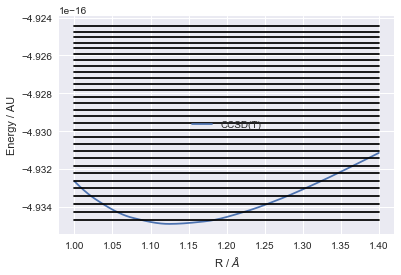

In [104]:
t = np.linspace(1.0, 1.4, 500)

plt.plot(t, interpolator_CCSDT(t), label="CCSD(T)")
for e in  eigsh(H_CCSDT, 30)[0]:
    plt.plot([1.0, 1.4], [e,e], "k-")


plt.xlabel("R / $\AA$")
plt.ylabel("Energy / AU")

plt.legend()